# Imports

In [1]:
using DataFrames
using CSV
using MLJ
using Flux
using Plots
using StatsBase
using MLJ: confusion_matrix

include("../../lib.jl")

ENV["LINES"]=50;

# Datasets

In [2]:
data = CSV.read("data.csv")

,Class_Name,Left_Weight,Left_Distance,Right_Weight,Right_Distance
,String,Int64,Int64,Int64,Int64
1,B,1,1,1,1
2,R,1,1,1,2
3,R,1,1,1,3
4,R,1,1,1,4
5,R,1,1,1,5
6,R,1,1,2,1
7,R,1,1,2,2
8,R,1,1,2,3
9,R,1,1,2,4


In [3]:
describe(data)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,Class_Name,,B,,R,3,,String
2,Left_Weight,3.0,1,3.0,5,,,Int64
3,Left_Distance,3.0,1,3.0,5,,,Int64
4,Right_Weight,3.0,1,3.0,5,,,Int64
5,Right_Distance,3.0,1,3.0,5,,,Int64


Look at class labels to see if dataset is imbalanced

In [4]:
label_counts = countmap(data[:Class_Name])

Dict{String,Int64} with 3 entries:
  "B" => 49
  "L" => 288
  "R" => 288

In [5]:
collect(label_counts[i] / size(data)[1] for i in keys(label_counts))

3-element Array{Float64,1}:
 0.0784
 0.4608
 0.4608

Get data ready for training

In [6]:
coerce!(data, :Class_Name=>Multiclass,
              :Left_Weight=>Continuous,
              :Right_Weight=>Continuous,
              :Left_Distance=>Continuous,
              :Right_Distance=>Continuous)
schema(data)

┌────────────────┬─────────────────────────────────┬───────────────┐
│ _.names        │ _.types                         │ _.scitypes    │
├────────────────┼─────────────────────────────────┼───────────────┤
│ Class_Name     │ CategoricalValue{String,UInt32} │ Multiclass{3} │
│ Left_Weight    │ Float64                         │ Continuous    │
│ Left_Distance  │ Float64                         │ Continuous    │
│ Right_Weight   │ Float64                         │ Continuous    │
│ Right_Distance │ Float64                         │ Continuous    │
└────────────────┴─────────────────────────────────┴───────────────┘
_.nrows = 625


In [7]:
y, X = unpack(data, ==(:Class_Name), colname->true)

(CategoricalValue{String,UInt32}["B", "R", "R", "R", "R", "R", "R", "R", "R", "R"  …  "L", "L", "L", "L", "L", "L", "L", "L", "L", "B"], 625×4 DataFrame
│ Row │ Left_Weight │ Left_Distance │ Right_Weight │ Right_Distance │
│     │ Float64     │ Float64       │ Float64      │ Float64        │
├─────┼─────────────┼───────────────┼──────────────┼────────────────┤
│ 1   │ 1.0         │ 1.0           │ 1.0          │ 1.0            │
│ 2   │ 1.0         │ 1.0           │ 1.0          │ 2.0            │
│ 3   │ 1.0         │ 1.0           │ 1.0          │ 3.0            │
│ 4   │ 1.0         │ 1.0           │ 1.0          │ 4.0            │
│ 5   │ 1.0         │ 1.0           │ 1.0          │ 5.0            │
│ 6   │ 1.0         │ 1.0           │ 2.0          │ 1.0            │
│ 7   │ 1.0         │ 1.0           │ 2.0          │ 2.0            │
│ 8   │ 1.0         │ 1.0           │ 2.0          │ 3.0            │
│ 9   │ 1.0         │ 1.0           │ 2.0          │ 4.0            │
│ 10  │

Partition train and test data accoring to class labels

In [8]:
# data to use when trying to fit a single validation set
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=123, stratify=values(data[:Class_Name])) # gives 70:30 split

([595, 102, 55, 568, 425, 389, 146, 63, 372, 250  …  195, 500, 571, 533, 112, 396, 297, 106, 303, 261], [444, 144, 546, 43, 19, 173, 365, 423, 27, 218  …  293, 614, 90, 471, 13, 134, 296, 79, 395, 415])

In [9]:
train_counts = countmap(data[train,:Class_Name])
collect(train_counts[i] / size(train)[1] for i in keys(train_counts))

3-element Array{Float64,1}:
 0.0776255707762557
 0.4611872146118721
 0.4611872146118721

In [10]:
test_counts = countmap(data[test,:Class_Name])
collect(test_counts[i] / size(test)[1] for i in keys(test_counts))

3-element Array{Float64,1}:
 0.08021390374331551
 0.45989304812834225
 0.45989304812834225

# Five Learning Algorithms

* Decision trees with some form of pruning
* Neural networks
* Boosting
* Support Vector Machines
* k-nearest neighbors


##### Testing
* Implement the algorithms
* Design two *interesting* classification problems. For the purposes of this assignment, a classification problem is just a set of training examples and a set of test examples.

In [11]:
models(matching(X,y))

42-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, ... )
 (name = BayesianQDA, package_name = ScikitLearn, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_na

In [12]:
@load NeuralNetworkClassifier verbosity=2

import MLJFlux 

┌ Info: Loading into module "Main": 
└ @ MLJModels /home/andrew/.julia/packages/MLJModels/mUBFt/src/loading.jl:70


✔
import MLJFlux ✔


NeuralNetworkClassifier(
    builder = Short(
            n_hidden = 0,
            dropout = 0.5,
            σ = NNlib.σ),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @171

## Neural networks
* Use favorite kind of network and training algorithm. 
* You may use networks of nodes with as many layers as you like and any activation function you see fit.

1. https://github.com/alan-turing-institute/MLJFlux.jl/blob/master/examples/boston.ipynb
1. https://github.com/alan-turing-institute/MLJFlux.jl
1. https://alan-turing-institute.github.io/MLJ.jl/dev/transformers/

In [13]:
# Define a custom network
mutable struct CustomNN <:MLJFlux.Builder
    n1 ::Int
#     n2 ::Int
end

In [14]:
function MLJFlux.build(nn::CustomNN, n_in, n_out)
    return Chain(
        Flux.Dense(n_in, nn.n1, σ),
#         Flux.Dense(nn.n1, nn.n2, σ),
        Flux.Dense(nn.n1, n_out, σ),
    )
end

In [15]:
layer1 = 34
# layer2 = 5

34

### No-preprocessing

In [17]:
nn = NeuralNetworkClassifier(builder=CustomNN(layer1))

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 34),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @574

In [18]:
Net = machine(nn, X, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @668 trained 0 times.
  args: 
    1:	Source @521 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @955 ⏎ `AbstractArray{Multiclass{3},1}`


In [19]:
nn.optimiser.eta = 0.001
nn.epochs = 60
nn.batch_size = 16
nn.lambda = 0.01

0.01

In [20]:
fit!(Net, rows=train, verbosity=2)

┌ Info: Training Machine{NeuralNetworkClassifier{CustomNN,…}} @668.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Loss is 0.9947
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9713
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9598
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9535
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9496
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9468
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9445
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9423
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9396
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.93

Machine{NeuralNetworkClassifier{CustomNN,…}} @668 trained 1 time.
  args: 
    1:	Source @521 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @955 ⏎ `AbstractArray{Multiclass{3},1}`


In [21]:
nn.optimiser.eta = nn.optimiser.eta / 3
nn.epochs = nn.epochs + 40

100

In [22]:
fit!(Net, rows=train, verbosity=2)

┌ Info: Updating Machine{NeuralNetworkClassifier{CustomNN,…}} @668.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:320
┌ Info: Loss is 0.6829
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6826
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6823
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6821
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6818
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6816
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6814
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6812
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6809
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.68

Machine{NeuralNetworkClassifier{CustomNN,…}} @668 trained 2 times.
  args: 
    1:	Source @521 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @955 ⏎ `AbstractArray{Multiclass{3},1}`


In [28]:
nn_acc = evaluate!(Net, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:02


┌───────────────┬───────────────┬──────────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                       │
├───────────────┼───────────────┼──────────────────────────────────────────────────┤
│ cross_entropy │ 0.702         │ Float32[0.694, 0.681, 0.713, 0.723, 0.689, 0.71] │
│ acc           │ 0.864         │ [0.886, 0.885, 0.837, 0.846, 0.875, 0.856]       │
└───────────────┴───────────────┴──────────────────────────────────────────────────┘
_.per_observation = [[[0.593, 0.561, ..., 1.46], [0.565, 0.585, ..., 0.584], [0.677, 0.67, ..., 0.578], [0.562, 1.03, ..., 0.558], [0.564, 0.554, ..., 0.688], [0.566, 0.587, ..., 0.563]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [29]:
fitted_params(Net)

(chain = Chain(Chain(Dense(4, 34, σ), Dense(34, 3, σ)), softmax),)

In [30]:
report(Net)

(training_losses = Any[1.0489224f0, 1.0270202f0, 1.0095178f0, 0.9956713f0, 0.9846867f0, 0.97588027f0, 0.9687133f0, 0.9627767f0, 0.95776117f0, 0.95343286f0  …  0.70278883f0, 0.7019947f0, 0.70122075f0, 0.70046645f0, 0.6997309f0, 0.6990136f0, 0.6983137f0, 0.6976309f0, 0.696964f0, 0.6963131f0],)

### With Preprocessing

In [31]:
nn2 = NeuralNetworkClassifier(builder=CustomNN(layer1))

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 34),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @489

In [32]:
nn2.optimiser.eta = 0.00032
nn2.batch_size = 16
nn2.lambda = 0.0021544346900318843

0.0021544346900318843

Standardizing Inputs makes a huge difference.
Before, I could only barely break below 0.4 training loss, but by standardizing inputs, I can easily get near 0.3.

In [33]:
standardizer = Standardizer()
stand = machine(standardizer, X[train,:]) #only want to standardize on training distribution
fit!(stand)
X_stand = MLJ.transform(stand, X);

┌ Info: Training Machine{Standardizer} @374.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


In [34]:
Net2 = machine(nn2, X_stand, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @905 trained 0 times.
  args: 
    1:	Source @126 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @510 ⏎ `AbstractArray{Multiclass{3},1}`


### Learning Curve

In [42]:
max_epochs = 2000;

In [43]:
nn2.epochs = max_epochs;

In [44]:
fit!(Net2, rows=train, verbosity=1, force=true)

┌ Info: Training Machine{NeuralNetworkClassifier{CustomNN,…}} @905.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Optimising neural net:100%[=========================] Time: 0:00:07


Machine{NeuralNetworkClassifier{CustomNN,…}} @905 trained 2 times.
  args: 
    1:	Source @126 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @510 ⏎ `AbstractArray{Multiclass{3},1}`


In [45]:
vals = collect(0:5:max_epochs)
r = range(nn2, :epochs, values=vals)
# r = range(nn2, :epochs, lower=0, upper=max_epochs)
curve = learning_curve(Net2, 
                        range=r, 
                        resampling=Holdout(fraction_train=0.7), 
#                         resampling=CV(nfolds=4), 
                        measure=cross_entropy, 
                        acceleration=CPUThreads())

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @398.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 401 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 401 metamodels: 100%[=========================] Time: 0:00:07


(parameter_name = "epochs",
 parameter_scale = :none,
 parameter_values = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45  …  1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000],
 measurements = [1.0289121866226196, 1.0148004293441772, 1.0120105743408203, 1.0106853246688843, 1.0061944723129272, 0.9976232051849365, 0.9854570031166077, 0.9704335927963257, 0.9532008171081543, 0.9343756437301636  …  0.641137421131134, 0.6410965323448181, 0.6410556435585022, 0.641014575958252, 0.6409735083580017, 0.6409323215484619, 0.6408909559249878, 0.6408495306968689, 0.6408080458641052, 0.6407663822174072],)

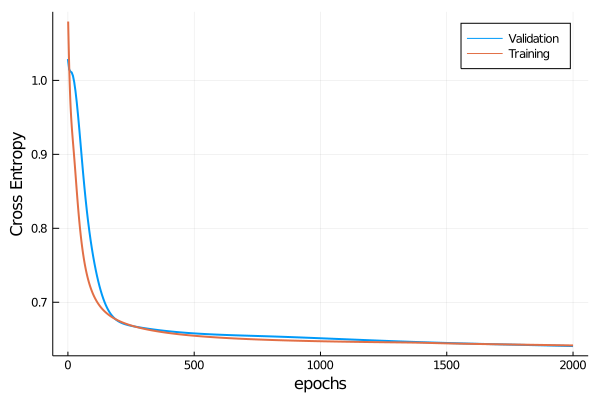

In [46]:
plot(curve.parameter_values,
     curve.measurements,
     xlab=curve.parameter_name,
     ylab="Cross Entropy",
     label="Validation", lw=2)
plot!(Net2.report.training_losses, label="Training", lw=2)

In [47]:
a = round(nn2.optimiser.eta, digits=5)
b = round(minimum(curve.measurements), digits=5)
a,b

(0.00032, 0.64077)

In [38]:
fn = "Figures/LearningCurve_NN_hidden:$(layer1)_epochs:$(nn2.epochs)_lr:$(a)_loss:$(b)_labmda:$(nn2.lambda)"
png(replace(fn,'.' => ','))

### GridSearch for Hidden Layer Size

In [57]:
param1 = :epochs
param2 = :(builder.n1)

r1 = range(nn2, param1, lower=10, upper=3000, scale=:log10)
r2 = range(nn2, param2, lower=1, upper=100, scale=:linear)

MLJBase.NumericRange(Int64, :(builder.n1), ... )

In [62]:
self_tuning_nn_model = TunedModel(model=nn2,
                                    tuning=Grid(goal=64),
                                    resampling=Holdout(fraction_train=0.7), 
                                    measure=cross_entropy,
                                    acceleration=CPUThreads(),
                                    range=[r1, r2])

ProbabilisticTunedModel(
    model = NeuralNetworkClassifier(
            builder = CustomNN @951,
            finaliser = NNlib.softmax,
            optimiser = ADAM(0.00032, (0.9, 0.999), IdDict{Any,Any}()),
            loss = Flux.crossentropy,
            epochs = 2000,
            batch_size = 16,
            lambda = 0.0021544346900318843,
            alpha = 0.0,
            optimiser_changes_trigger_retraining = false),
    tuning = Grid(
            goal = 64,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.7,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{Int64,MLJBase.Bounded,Symbol}[NumericRange{Int64,…} @450, NumericRange{Int64,…} @524],
    train_best = true,
    repeats = 1,
 

In [63]:
self_tuning_nn = machine(self_tuning_nn_model, X_stand, y)

Machine{ProbabilisticTunedModel{Grid,…}} @423 trained 0 times.
  args: 
    1:	Source @193 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @657 ⏎ `AbstractArray{Multiclass{3},1}`


In [64]:
z = fit!(self_tuning_nn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @423.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 64 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 64 metamodels: 100%[=========================] Time: 0:01:52


Machine{ProbabilisticTunedModel{Grid,…}} @423 trained 1 time.
  args: 
    1:	Source @193 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @657 ⏎ `AbstractArray{Multiclass{3},1}`


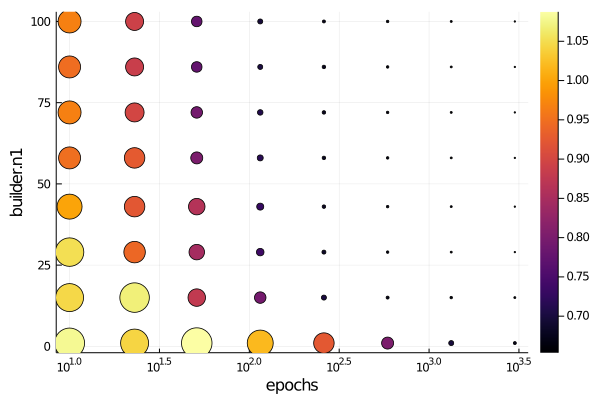

In [65]:
plot(self_tuning_nn)

In [66]:
best = fitted_params(self_tuning_nn)
best

(best_model = NeuralNetworkClassifier{CustomNN,…} @051,
 best_fitted_params = (chain = Chain(Chain(Dense(4, 100, σ), Dense(100, 3, σ)), softmax),),)

In [67]:
best.best_model

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 100),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.00032, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 3000,
    batch_size = 16,
    lambda = 0.0021544346900318843,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @051

In [68]:
best_loss = z.report.best_result.measurement[1]

0.65345985f0

In [97]:
best_n1 = best.best_model.builder.n1

34

In [48]:
fn = "Figures/Grid_NN_$(param1):$(a)_x_$(param2):$(b)_bestloss:$(best_loss)_lr:$c"
png(replace(fn,'.' => ','))

### GridSearch for Learning Rate

In [70]:
param1 = :epochs
param2 = :(optimiser.eta)

r1 = range(nn2, param1, lower=10, upper=1000, scale=:linear)
r2 = range(nn2, param2, lower=0.00001, upper=0.01, scale=:log10)

MLJBase.NumericRange(Float64, :(optimiser.eta), ... )

In [71]:
self_tuning_nn_model = TunedModel(model=nn2,
                                    tuning=Grid(goal=50),
                                    resampling=Holdout(fraction_train=0.7), 
                                    measure=cross_entropy,
                                    acceleration=CPUThreads(),
                                    range=[r1, r2])

ProbabilisticTunedModel(
    model = NeuralNetworkClassifier(
            builder = CustomNN @951,
            finaliser = NNlib.softmax,
            optimiser = ADAM(0.00032, (0.9, 0.999), IdDict{Any,Any}()),
            loss = Flux.crossentropy,
            epochs = 2000,
            batch_size = 16,
            lambda = 0.0021544346900318843,
            alpha = 0.0,
            optimiser_changes_trigger_retraining = false),
    tuning = Grid(
            goal = 50,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.7,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{T,MLJBase.Bounded,Symbol} where T[NumericRange{Int64,…} @873, NumericRange{Float64,…} @713],
    train_best = true,
    repeats 

In [72]:
self_tuning_nn = machine(self_tuning_nn_model, X_stand, y)

Machine{ProbabilisticTunedModel{Grid,…}} @586 trained 0 times.
  args: 
    1:	Source @246 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @836 ⏎ `AbstractArray{Multiclass{3},1}`


In [73]:
z = fit!(self_tuning_nn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @586.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 49 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 49 metamodels: 100%[=========================] Time: 0:00:40


Machine{ProbabilisticTunedModel{Grid,…}} @586 trained 1 time.
  args: 
    1:	Source @246 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @836 ⏎ `AbstractArray{Multiclass{3},1}`


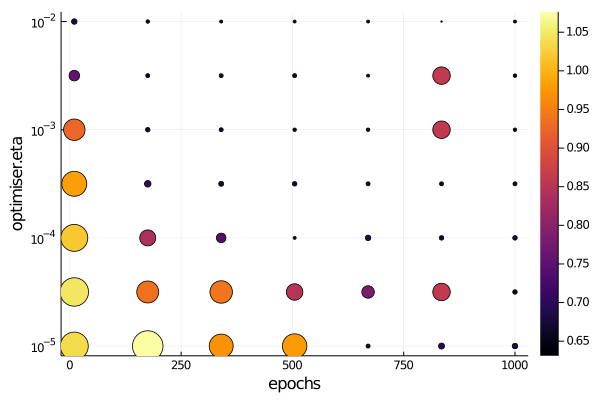

In [74]:
plot(self_tuning_nn)

In [75]:
best = fitted_params(self_tuning_nn)
best

(best_model = NeuralNetworkClassifier{CustomNN,…} @428,
 best_fitted_params = (chain = Chain(Chain(Dense(4, 34, σ), Dense(34, 3, σ)), softmax),),)

In [76]:
best.best_model

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 34),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.01, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 835,
    batch_size = 16,
    lambda = 0.0021544346900318843,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @428

In [77]:
best_loss = z.report.best_result.measurement[1]

0.63109577f0

In [111]:
best_eta = round(best.best_model.optimiser.eta, digits=5)

0.00032

In [130]:
fn = "Figures/Grid_NN_$(param1):$(a)_x_$(param2):$(c)_bestloss:$(best_loss)_hidden:$b"
png(replace(fn,'.' => ','))

### GridSearch for Regularization

In [100]:
param1 = :epochs
param2 = :lambda

r1 = range(nn2, param1, lower=100, upper=2000, scale=:linear)
r2 = range(nn2, param2, lower=0.0001, upper=10, scale=:log10)

MLJBase.NumericRange(Float64, :lambda, ... )

In [101]:
self_tuning_nn_model = TunedModel(model=nn2,
                                    tuning=Grid(goal=50),
                                    resampling=Holdout(fraction_train=0.7), 
                                    measure=cross_entropy,
                                    acceleration=CPUThreads(),
                                    range=[r1, r2])

ProbabilisticTunedModel(
    model = NeuralNetworkClassifier(
            builder = CustomNN @951,
            finaliser = NNlib.softmax,
            optimiser = ADAM(0.00032, (0.9, 0.999), IdDict{Any,Any}()),
            loss = Flux.crossentropy,
            epochs = 2000,
            batch_size = 16,
            lambda = 0.0021544346900318843,
            alpha = 0.0,
            optimiser_changes_trigger_retraining = false),
    tuning = Grid(
            goal = 50,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.7,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{T,MLJBase.Bounded,Symbol} where T[NumericRange{Int64,…} @889, NumericRange{Float64,…} @990],
    train_best = true,
    repeats 

In [102]:
self_tuning_nn = machine(self_tuning_nn_model, X_stand, y)

Machine{ProbabilisticTunedModel{Grid,…}} @182 trained 0 times.
  args: 
    1:	Source @806 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @908 ⏎ `AbstractArray{Multiclass{3},1}`


In [103]:
z = fit!(self_tuning_nn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @182.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 49 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 49 metamodels: 100%[=========================] Time: 0:02:05


Machine{ProbabilisticTunedModel{Grid,…}} @182 trained 1 time.
  args: 
    1:	Source @806 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @908 ⏎ `AbstractArray{Multiclass{3},1}`


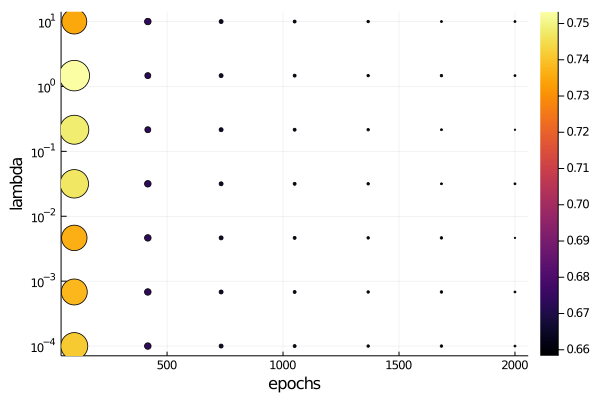

In [104]:
plot(self_tuning_nn)

In [105]:
best = fitted_params(self_tuning_nn)
best

(best_model = NeuralNetworkClassifier{CustomNN,…} @206,
 best_fitted_params = (chain = Chain(Chain(Dense(4, 34, σ), Dense(34, 3, σ)), softmax),),)

In [106]:
best.best_model

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 34),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.00032, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 2000,
    batch_size = 16,
    lambda = 0.004641588833612777,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @206

In [107]:
best_loss = z.report.best_result.measurement[1]

0.65833664f0

In [108]:
best_lambda = best.best_model.lambda

0.004641588833612777

In [68]:
fn = "Figures/Grid_NN_$(param1):$(a)_x_$(param2):$(c)_bestloss:$(best_loss)_hidden:$b"
png(replace(fn,'.' => ','))

### Learning Curve

In [122]:
lc_model = NeuralNetworkClassifier(builder=CustomNN(best_n1),
                                        lambda = best_lambda,
                                        epochs = 3000)
lc_model.optimiser.eta = best_eta;

In [123]:
data_schedule, training_losses, valid_losses = learn_curve(lc_model, X[train,:], y[train], acc)

(d, train_metric, valid_metric) = (10, 1.0, 0.5909090909090909)
(d, train_metric, valid_metric) = (15, 1.0, 0.6477272727272727)
(d, train_metric, valid_metric) = (20, 0.95, 0.8295454545454546)
(d, train_metric, valid_metric) = (25, 0.92, 0.8636363636363636)
(d, train_metric, valid_metric) = (30, 0.9, 0.875)
(d, train_metric, valid_metric) = (35, 0.8857142857142857, 0.875)
(d, train_metric, valid_metric) = (40, 0.875, 0.8863636363636364)
(d, train_metric, valid_metric) = (45, 0.8666666666666667, 0.8863636363636364)
(d, train_metric, valid_metric) = (50, 0.88, 0.8863636363636364)
(d, train_metric, valid_metric) = (55, 0.8909090909090909, 0.875)
(d, train_metric, valid_metric) = (60, 0.8833333333333333, 0.9090909090909091)
(d, train_metric, valid_metric) = (65, 0.8461538461538461, 0.8863636363636364)
(d, train_metric, valid_metric) = (70, 0.8571428571428571, 0.875)
(d, train_metric, valid_metric) = (75, 0.8533333333333334, 0.9090909090909091)
(d, train_metric, valid_metric) = (80, 0.8625,

(10:5:350, Any[1.0, 1.0, 0.95, 0.92, 0.9, 0.8857142857142857, 0.875, 0.8666666666666667, 0.88, 0.8909090909090909  …  0.9049180327868852, 0.9064516129032258, 0.9079365079365079, 0.909375, 0.9076923076923077, 0.9090909090909091, 0.9104477611940298, 0.9117647058823529, 0.9101449275362319, 0.9114285714285715], Any[0.5909090909090909, 0.6477272727272727, 0.8295454545454546, 0.8636363636363636, 0.875, 0.875, 0.8863636363636364, 0.8863636363636364, 0.8863636363636364, 0.875  …  0.9318181818181818, 0.9318181818181818, 0.9318181818181818, 0.9318181818181818, 0.9318181818181818, 0.9318181818181818, 0.9318181818181818, 0.9431818181818182, 0.9318181818181818, 0.9318181818181818])

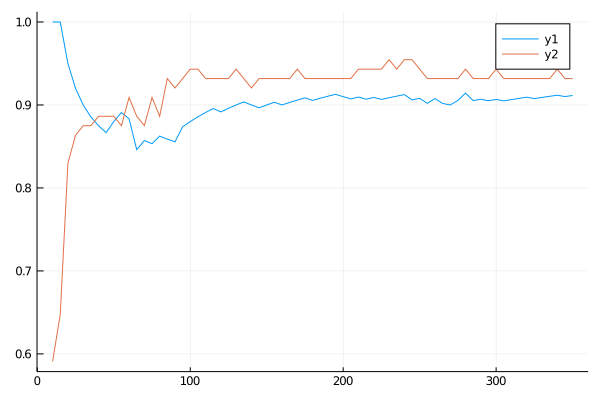

In [124]:
plot(data_schedule, training_losses)
plot!(data_schedule, valid_losses)

In [126]:
png("learning_curve_nn_3000epochs_balance")

# Final Results

In [140]:
final_model = NeuralNetworkClassifier(builder=CustomNN(best_n1),
                                        lambda = best_lambda,
                                        epochs = 3000,
                                        optimiser.eta = best_eta)

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 34),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @789

### Test Performance

In [70]:
final_model.optimiser.eta = 0.00032
final_model.batch_size = 16
final_model.lambda = 0.0021544346900318843
final_model.epochs = 1000

1000

In [71]:
Final_Net = machine(final_model, X_stand, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @036 trained 0 times.
  args: 
    1:	Source @592 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @319 ⏎ `AbstractArray{Multiclass{2},1}`


In [72]:
fit!(Final_Net, rows=train, force=true, verbosity=1)

┌ Info: Training Machine{NeuralNetworkClassifier{CustomNN,…}} @036.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Optimising neural net:100%[=========================] Time: 0:00:04


Machine{NeuralNetworkClassifier{CustomNN,…}} @036 trained 1 time.
  args: 
    1:	Source @592 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @319 ⏎ `AbstractArray{Multiclass{2},1}`


In [73]:
vals = collect(0:5:max_epochs)
r = range(final_model, :epochs, values=vals)
# r = range(nn2, :epochs, lower=0, upper=max_epochs)
curve = learning_curve(Final_Net, 
                        range=r, 
                        resampling=Holdout(fraction_train=0.7), 
#                         resampling=CV(nfolds=4), 
                        measure=cross_entropy, 
                        acceleration=CPUThreads())

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @863.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 201 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 201 metamodels: 100%[=========================] Time: 0:00:04


(parameter_name = "epochs",
 parameter_scale = :none,
 parameter_values = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45  …  955, 960, 965, 970, 975, 980, 985, 990, 995, 1000],
 measurements = [0.7132737636566162, 0.5794021487236023, 0.49399223923683167, 0.44282054901123047, 0.41152235865592957, 0.39161020517349243, 0.3784363865852356, 0.3694179356098175, 0.3630272150039673, 0.35831645131111145  …  0.33712613582611084, 0.33711642026901245, 0.33710598945617676, 0.3370960056781769, 0.33708617091178894, 0.3370766043663025, 0.337067574262619, 0.33705905079841614, 0.3370507061481476, 0.3370422124862671],)

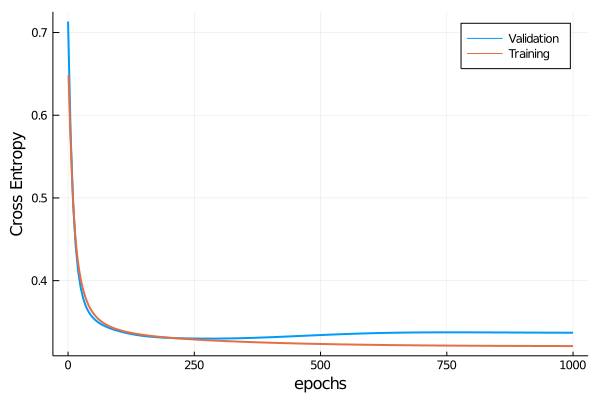

In [74]:
plot(curve.parameter_values,
     curve.measurements,
     xlab=curve.parameter_name,
     ylab="Cross Entropy",
     label="Validation", lw=2)
plot!(Final_Net.report.training_losses, label="Training", lw=2)

In [75]:
nn_acc = evaluate!(Final_Net, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:33


┌───────────────┬───────────────┬──────────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                       │
├───────────────┼───────────────┼──────────────────────────────────────────────────┤
│ cross_entropy │ 0.342         │ Float32[0.365, 0.326, 0.33, 0.324, 0.356, 0.353] │
│ acc           │ 0.967         │ [0.937, 0.989, 0.979, 0.989, 0.947, 0.957]       │
└───────────────┴───────────────┴──────────────────────────────────────────────────┘
_.per_observation = [[[0.313, 0.313, ..., 0.313], [0.313, 0.313, ..., 0.313], [0.313, 0.313, ..., 0.313], [0.313, 0.313, ..., 0.313], [0.313, 0.313, ..., 1.31], [0.313, 0.313, ..., 0.313]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [76]:
nn_acc = evaluate!(Final_Net, resampling=CV(shuffle=true), measure=[tnr,tpr,fnr,fpr], verbosity=1, operation=predict_mode)

┌ Warning: The classes are un-ordered,
│ using: negative='B' and positive='M'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/measures/confusion_matrix.jl:83
┌ Warning: The classes are un-ordered,
│ using: negative='B' and positive='M'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/measures/confusion_matrix.jl:83
┌ Warning: The classes are un-ordered,
│ using: negative='B' and positive='M'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/measures/confusion_matrix.jl:83
┌ Warning: The classes are un-ordered,
│ using: negative='B' and positive='M'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/measures/confusion_matrix.jl:83
Evaluating over 6 folds:  17%[====>                    ]  ETA: 0

┌─────────────────────┬───────────────┬──────────────────────────────────────────────────┐
│ _.measure           │ _.measurement │ _.per_fold                                       │
├─────────────────────┼───────────────┼──────────────────────────────────────────────────┤
│ true_negative_rate  │ 0.985         │ [1.0, 0.966, 0.967, 1.0, 0.98, 1.0]              │
│ true_positive_rate  │ 0.947         │ [0.962, 0.919, 0.912, 0.941, 0.978, 0.971]       │
│ false_negative_rate │ 0.0528        │ [0.0385, 0.0811, 0.0882, 0.0588, 0.0217, 0.0286] │
│ false_positive_rate │ 0.0146        │ [0.0, 0.0345, 0.0328, 0.0, 0.0204, 0.0]          │
└─────────────────────┴───────────────┴──────────────────────────────────────────────────┘
_.per_observation = [missing, missing, missing, missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [77]:
ŷ = MLJ.predict(Final_Net, X_stand[test,:]);

In [78]:
cross_entropy(ŷ, y[test]) |> mean

0.3249617f0

In [79]:
acc(ŷ, y[test])

0.9883040935672515

In [80]:
confusion_matrix(mode.(ŷ), y[test])

┌ Warning: The classes are un-ordered,
│ using: negative='B' and positive='M'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/measures/confusion_matrix.jl:83


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      B      │      M      │
├─────────────┼─────────────┼─────────────┤
│      B      │     107     │      2      │
├─────────────┼─────────────┼─────────────┤
│      M      │      0      │     62      │
└─────────────┴─────────────┴─────────────┘


In [81]:
fitted_params(Final_Net)

(chain = Chain(Chain(Dense(30, 34, σ), Dense(34, 2, σ)), softmax),)

In [82]:
report(Final_Net)

(training_losses = Any[0.66932636f0, 0.6344296f0, 0.60356635f0, 0.576627f0, 0.55337256f0, 0.5333697f0, 0.5161165f0, 0.5011453f0, 0.48806328f0, 0.4765533f0  …  0.32163554f0, 0.32163522f0, 0.32163486f0, 0.3216345f0, 0.32163426f0, 0.3216339f0, 0.32163364f0, 0.3216333f0, 0.321633f0, 0.32163274f0],)

A lot slower than Holdout

In [83]:
# self_tuning_nn_model = TunedModel(model=nn2,
#                                     tuning=Grid(goal=50),
#                                     resampling=CV(), 
#                                     measure=cross_entropy,
#                                     acceleration=CPUThreads(),
#                                     range=[r_its, r_lr])

# self_tuning_nn = machine(self_tuning_nn_model, X_stand, y)

In [84]:
# fit!(self_tuning_nn)

In [85]:
# plot(self_tuning_nn)